In [171]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn

from models import LinearTemporalConvNet
from utils import output_metric_fns

In [172]:
kernel_size = 1024

model = LinearTemporalConvNet(hidden_sizes=[1],kernel_size=kernel_size,bias=False)
# For convolution kernels, the memory length is bounded by kernel_size

In [173]:
state_dict = model.state_dict()

pol_weights = torch.tensor([1 / (kernel_size - i)**1.2 for i in range(kernel_size)], dtype=torch.float32).reshape(1, 1, kernel_size)
exp_weights = torch.tensor([1 / 1.2**(kernel_size - i) for i in range(kernel_size)], dtype=torch.float32).reshape(1, 1, kernel_size)
state_dict[list(state_dict.keys())[0]] = pol_weights

model.load_state_dict(state_dict)

<All keys matched successfully>

In [174]:
T = 1024
inputs = torch.zeros(1, T, 1) # B * T * D
inputs[:,0,:] = 1
# print(inputs)

# print(dict(model.named_parameters()))
# print(list(model.parameters()))
outputs = model(inputs)
print("Outputs shape is", outputs.shape)
# print("Outputs is", outputs)

Outputs shape is torch.Size([1, 1024, 1])


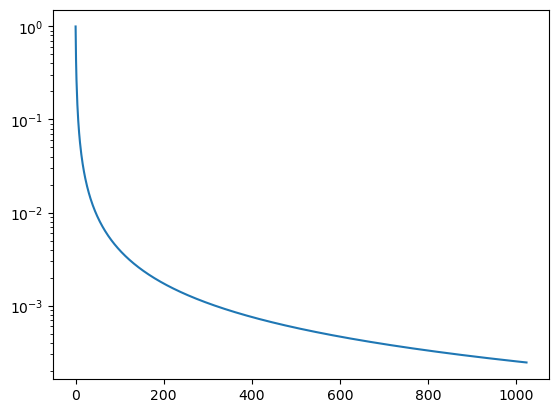

In [175]:
squeezed_outputs = torch.squeeze(outputs).detach().numpy()
# print(squeezed_outputs)
plt.plot(squeezed_outputs)
# memory = squeezed_outputs[1:] - squeezed_outputs[:-1]
# memory = np.abs(memory)
# print("Memory shape is", memory.shape)
# print(memory)
# plt.plot(memory)

plt.yscale('log')
plt.show()

In [176]:
pol_weights[:,:,-1] = pol_weights[:,:,-1] + 1 # rho[0] perturbed by 1
state_dict[list(state_dict.keys())[0]] = pol_weights
model_head = copy.deepcopy(model)
model_head.load_state_dict(state_dict)
pol_weights[:,:,-1] = pol_weights[:,:,-1] - 1

pol_weights[:,:,0] = pol_weights[:,:,0] + 1 # rho[T-1] perturbed by 1
state_dict[list(state_dict.keys())[0]] = pol_weights
model_tail = copy.deepcopy(model)
model_tail.load_state_dict(state_dict)
pol_weights[:,:,0] = pol_weights[:,:,0] - 1

inputs = torch.randn(10, T, 1) # B * T * D

for p in [0, 1, 2, 10]:
    print(output_metric_fns[f"mse_wl{p}"](model(inputs), model_head(inputs)), output_metric_fns[f"mse_wl{p}"](model(inputs), model_tail(inputs)))
    print("Ratio", output_metric_fns[f"mse_wl{p}"](model(inputs), model_head(inputs)) / output_metric_fns[f"mse_wl{p}"](model(inputs), model_tail(inputs)))

tensor(9.4890e-07, grad_fn=<MseLossBackward0>) tensor(1.2659e-09, grad_fn=<MseLossBackward0>)
Ratio tensor(749.5929, grad_fn=<DivBackward0>)
tensor(1.2871e-06, grad_fn=<MseLossBackward0>) tensor(5.0537e-09, grad_fn=<MseLossBackward0>)
Ratio tensor(254.6794, grad_fn=<DivBackward0>)
tensor(1.7439e-06, grad_fn=<MseLossBackward0>) tensor(1.1360e-08, grad_fn=<MseLossBackward0>)
Ratio tensor(153.5164, grad_fn=<DivBackward0>)
tensor(5.4967e-06, grad_fn=<MseLossBackward0>) tensor(1.5154e-07, grad_fn=<MseLossBackward0>)
Ratio tensor(36.2730, grad_fn=<DivBackward0>)
